# Conventional Convolutionary Neural Network for QM7

In [ ]:
%%shell
jupyter nbconvert --to html /content/Project.ipynb

[NbConvertApp] Converting notebook /content/Project.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 23 image(s).
[NbConvertApp] Writing 1307242 bytes to /content/Project.html


In [2]:
# Install PyTorch Geometric
!pip install --upgrade torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
import scipy.linalg

import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import QM7b
from torch_geometric.loader import DataLoader
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [4]:
dataset = QM7b(root='/tmp/QM7b')

Processing...
Done!


Since QM7b does not have features, we generate the Coulomb_matrix as features for the inputs. The input matrix now have a shape of 7211 x 23 x 23. The output matrix have a shape of 7211 x 1(atomization energy).

In [6]:
def create_coulomb_from_dataset(dataset, max_atoms=23, target_idx=0):
    """
    Build Coulomb matrix：
    - data.edge_index: [2, E]
    - data.edge_attr:  [E]，
    - data.y:          [1, 14]，14 targets
    """
    features = []
    targets = []

    for data in dataset:
        edge_index = data.edge_index.cpu().numpy()   # shape: (2, E)
        edge_attr  = data.edge_attr.cpu().numpy()    # shape: (E,)
        y          = float(data.y[0, target_idx])

        num_nodes = data.num_nodes
        n = min(num_nodes, max_atoms)

        M = np.zeros((max_atoms, max_atoms), dtype=np.float32)


        for k in range(edge_attr.shape[0]):
            i = edge_index[0, k]
            j = edge_index[1, k]
            if i < max_atoms and j < max_atoms:
                M[i, j] = edge_attr[k]

        features.append(M)
        targets.append(y)

    return np.array(features), np.array(targets, dtype=np.float32)

In [7]:
# Create Coulomb matrices
X_coulomb, y_coulomb = create_coulomb_from_dataset(dataset)
y_coulomb = y_coulomb.reshape(-1, 1)
print(f"Coulomb matrices: {X_coulomb.shape}")
print(f"target shape: {y_coulomb.shape}")
print(f"Sample Coulomb matrix:\n{X_coulomb[0, :5, :5]}")
print(f"Sample atomization Energy:\n{y_coulomb[:5]}")
print(y_coulomb.min(), y_coulomb.max(), y_coulomb.mean())


Coulomb matrices: (7211, 23, 23)
target shape: (7211, 1)
Sample Coulomb matrix:
[[36.858105    2.8961232   2.896139    2.8960826   2.896124  ]
 [ 2.8961232   0.5         0.29557988  0.29558712  0.2955819 ]
 [ 2.896139    0.29557988  0.5         0.29558566  0.29558027]
 [ 2.8960826   0.29558712  0.29558566  0.5         0.29558742]
 [ 2.896124    0.2955819   0.29558027  0.29558742  0.5       ]]
Sample atomization Energy:
[[-420.93375]
 [-718.4192 ]
 [-570.02484]
 [-410.28616]
 [-868.8554 ]]
-2212.5664 -410.28616 -1563.3252


In [8]:
def sort_coulomb_matrices(X_coulomb):
    """Sort Coulomb matrices by row-norm.
    Args:
    X_coulomb: (N, A, A)
    """
    X_sorted = np.empty_like(X_coulomb)
    for i in range(len(X_coulomb)):
        M = X_coulomb[i]
        # L2 norm for each row
        row_norms = np.linalg.norm(M, axis=1)
        # sort in ascending order
        order = np.argsort(row_norms)[::-1]
        M_sorted = M[order][:, order]
        X_sorted[i] = M_sorted
    return X_sorted

In [9]:
def create_data_loaders(
    X_coulomb,
    y_coulomb,
    test_size=0.2,
    batch_size=32,
    random_state=42
):
    """Create train / val / test DataLoaders for Coulomb matrix + CNN"""

    # sort coulomb matrix by row-norm
    X_coulomb_sorted = sort_coulomb_matrices(X_coulomb)  # shape: (N, A, A)


    X_train_val, X_test, y_train_val, y_test_raw = train_test_split(
        X_coulomb_sorted, y_coulomb,
        test_size=test_size,
        random_state=random_state,
        shuffle=True
    )

    X_train, X_val, y_train_raw, y_val_raw = train_test_split(
        X_train_val, y_train_val,
        test_size=test_size,
        random_state=random_state,
        shuffle=True
    )

    # Per feature normalization
    #    X_train's shape: (N_train, A, A)
    X_mean = np.mean(X_train, axis=0)   # shape: (A, A)
    X_std = np.std(X_train, axis=0)     # shape: (A, A)

    X_std[X_std == 0] = 1.0

    X_train_norm = (X_train - X_mean) / X_std
    X_val_norm   = (X_val   - X_mean) / X_std
    X_test_norm  = (X_test  - X_mean) / X_std


    mean_y = np.mean(y_train_raw)
    std_y  = np.std(y_train_raw)
    if std_y == 0:
        std_y = 1.0

    y_train_norm = (y_train_raw - mean_y) / std_y
    y_val_norm   = (y_val_raw   - mean_y) / std_y
    y_test_norm  = (y_test_raw  - mean_y) / std_y


    X_train_tensor = torch.FloatTensor(X_train_norm).unsqueeze(1)  # (N, 1, A, A)
    X_val_tensor   = torch.FloatTensor(X_val_norm).unsqueeze(1)
    X_test_tensor  = torch.FloatTensor(X_test_norm).unsqueeze(1)

    y_train_tensor = torch.FloatTensor(y_train_norm)
    y_val_tensor   = torch.FloatTensor(y_val_norm)
    y_test_tensor  = torch.FloatTensor(y_test_norm)

    # 6. Dataset & DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)
    test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    print(f"Training batches:   {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches:       {len(test_loader)}")


    scaler_y = {
        'mean': np.float32(mean_y),
        'std':  np.float32(std_y),
    }


    return (
        train_loader,
        val_loader,
        test_loader,
        (X_train_tensor, y_train_tensor,
         X_val_tensor,   y_val_tensor,
         X_test_tensor,  y_test_tensor),
        scaler_y
    )

In [10]:
import torch.nn.functional as F

class SimpleCoulombCNN(nn.Module):
    def __init__(self, input_channels=1, num_properties=1, dropout=0.1):
        super(SimpleCoulombCNN, self).__init__()

        # 2 Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        # Global Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # fully connected layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, num_properties)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [N, 1, 23, 23]
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)   # 23 -> 11

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)   # 11 -> 5

        # Global average pooling: [N, 64, 5, 5] -> [N, 64, 1, 1]
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # [N, 64]

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)  # [N, 1]

        return x


In [11]:
class medium_complexity_CoulombCNN(nn.Module):
    def __init__(self, dropout1, dropout2, input_channels=1, num_properties=1):
        super(medium_complexity_CoulombCNN, self).__init__()

        # 64 -> 128 -> 256
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),    # 23 -> 11

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),    # 11 -> 5

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # 5x5 -> 1x1
            nn.Flatten(),     # -> (N, 128)
        )


        self.regressor = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout2),
            nn.Linear(64, num_properties),
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        return self.regressor(x)


In [12]:
class CoulombCNN(nn.Module):
    def __init__(self, dropout1, dropout2, input_channels=1, num_properties=1):
        super(CoulombCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 23x23 -> 11x11

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 11x11 -> 5x5

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((3, 3)),  # 5x5 -> 3x3

            nn.Flatten(),
        )

        self.regressor = nn.Sequential(
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(),
            nn.Dropout(dropout1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_properties)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        return self.regressor(x)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluation of Model
As stated, we used the validation MAE in kcal/mol as the main matric to evaluate our model.

In [14]:
def evaluate(model, loader, criterion, device, scaler=None):
    model.eval()
    val_loss = 0
    preds = []
    trues = []
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            val_loss += criterion(output, batch_y).item()
            preds.append(output.cpu().numpy())
            trues.append(batch_y.cpu().numpy())
    val_loss /= len(loader)
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    if scaler:
        preds = preds * scaler['std'] + scaler['mean']
        trues = trues * scaler['std'] + scaler['mean']
    # MAE/RMSE
    mae = np.mean(np.abs(preds - trues))
    rmse = np.sqrt(np.mean((preds - trues)**2))
    return val_loss, mae, rmse


# Training Loop
The initial training loop for the CNN is implemented below. It uses an Adam optimizer with weight decay=1e-5, ReduceLROnPlateau scheduler and MSE Loss since we are doing regression.

In [21]:
def train_coulomb_cnn(config, X, y):
    """Train CNN on Coulomb matrix features"""
    # Create dataloaders
    data = create_data_loaders(
    X, y, test_size=0.2, batch_size=config['batch_size'], random_state=42
    )

    train_loader = data[0]
    val_loader = data[1]
    test_loader = data[2]
    tensors = data[3]
    scaler_y = data[4]

    # Initialize model
    model = CoulombCNN(dropout1=config['dropout1'], dropout2=config['dropout2'], input_channels=1, num_properties=1)
    #model = SimpleCoulombCNN(input_channels=1, num_properties=1, dropout=config['dropout1'])

    # device setting
    model = model.to(device)

    criterion = nn.MSELoss() # MSE, initial model
    #criterion = nn.SmoothL1Loss() # Huber, final model
    optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    # Training loop
    train_losses = []
    val_losses = []
    val_maes = []
    val_rmses = []
    best_val_loss = float('inf')

    model.train()
    for epoch in range(config['num_epochs']):
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss, mae, rmse = evaluate(model, val_loader, criterion, device, scaler=scaler_y)
        val_losses.append(val_loss)
        val_maes.append(mae)
        val_rmses.append(rmse)
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config.get('early_stop_patience', 10):
                print(f"Early stopping at epoch {epoch+1}")
                break
        if epoch % 5 == 0:
          print(f"Epoch {epoch+1}/{config['num_epochs']} - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Plot loss curve
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_maes': val_maes,
        'val_rmses': val_rmses,
        'scaler': scaler_y,
        'config': config,
        'test_loader': test_loader
    }

# Hyperparameter tuning
We decided to use a random hyperparameter search to tune our model parameters.

In [16]:
import random

def random_hyperparameter_search(X, y, lr_list, batch_size_list, dropout1_list, dropout2_list, num_trials=10):
    results = []

    for trial in range(num_trials):
        # choose random parameters
        config = {
            'lr': random.choice(lr_list),
            'batch_size': random.choice(batch_size_list),
            'dropout1': random.choice(dropout1_list),
            'dropout2': random.choice(dropout2_list),
            'num_epochs': 5,
            'early_stop_patience': 10
        }
        print(f"\nTrial {trial+1}/{num_trials} with config: {config}")

        # train model
        output = train_coulomb_cnn(config, X, y)
        # record MAE
        final_mae = output['val_maes'][-1]
        results.append({'config': config, 'final_mae': final_mae})
        print(f"Trial {trial+1} finished: Final Val MAE = {final_mae:.4f}")

    # Find best by sorting
    results_sorted = sorted(results, key=lambda x: x['final_mae'])
    best = results_sorted[0]
    print(f"\nBest config: {best['config']}, MAE: {best['final_mae']:.4f}")

    return results_sorted


Trial 1/10 with config: {'lr': 0.0005, 'batch_size': 32, 'dropout1': 0.4, 'dropout2': 0.1, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   145
Validation batches: 37
Test batches:       46
Epoch 1/5 - Train Loss: 0.1088, Val Loss: 0.0418, MAE: 37.7572, RMSE: 45.9696
Epoch 2/5 - Train Loss: 0.0333, Val Loss: 0.0181, MAE: 23.6826, RMSE: 30.3812
Epoch 3/5 - Train Loss: 0.0191, Val Loss: 0.0133, MAE: 20.1704, RMSE: 25.7421
Epoch 4/5 - Train Loss: 0.0182, Val Loss: 0.0259, MAE: 27.5055, RMSE: 35.4026
Epoch 5/5 - Train Loss: 0.0134, Val Loss: 0.0123, MAE: 19.0251, RMSE: 24.9368


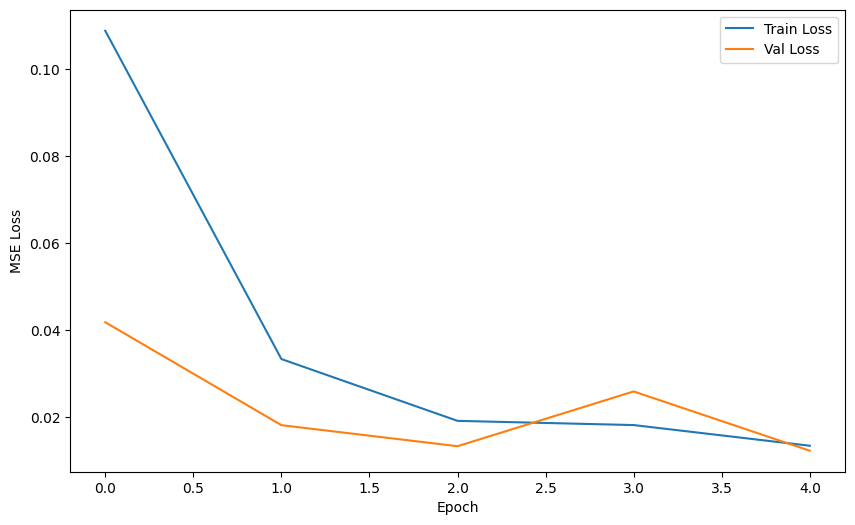

Trial 1 finished: Final Val MAE = 19.0251

Trial 2/10 with config: {'lr': 0.001, 'batch_size': 16, 'dropout1': 0.4, 'dropout2': 0.3, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   289
Validation batches: 73
Test batches:       91
Epoch 1/5 - Train Loss: 0.1232, Val Loss: 0.0443, MAE: 39.3378, RMSE: 47.2440
Epoch 2/5 - Train Loss: 0.0311, Val Loss: 0.0191, MAE: 23.9922, RMSE: 30.7193
Epoch 3/5 - Train Loss: 0.0217, Val Loss: 0.0222, MAE: 23.8931, RMSE: 33.3904
Epoch 4/5 - Train Loss: 0.0179, Val Loss: 0.0114, MAE: 18.6369, RMSE: 23.8359
Epoch 5/5 - Train Loss: 0.0156, Val Loss: 0.0090, MAE: 16.2496, RMSE: 21.1965


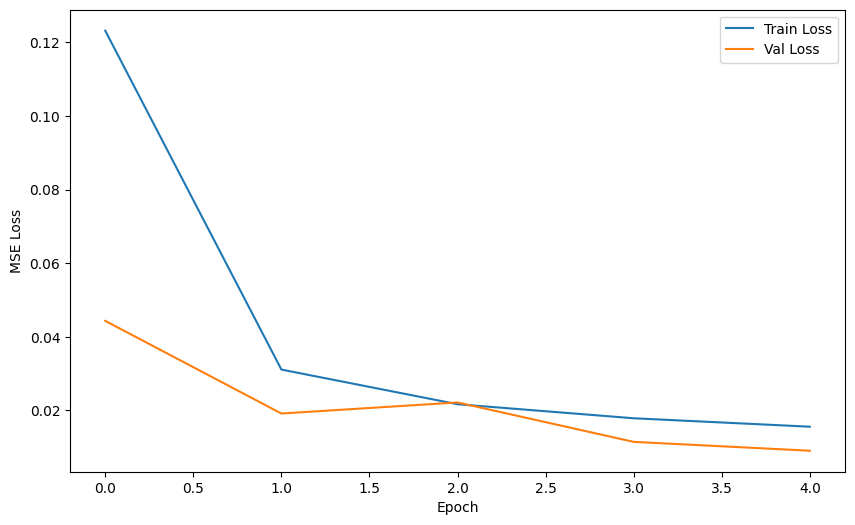

Trial 2 finished: Final Val MAE = 16.2496

Trial 3/10 with config: {'lr': 0.001, 'batch_size': 16, 'dropout1': 0.3, 'dropout2': 0.2, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   289
Validation batches: 73
Test batches:       91
Epoch 1/5 - Train Loss: 0.1035, Val Loss: 0.0902, MAE: 45.0658, RMSE: 67.0767
Epoch 2/5 - Train Loss: 0.0343, Val Loss: 0.0181, MAE: 24.1922, RMSE: 30.1386
Epoch 3/5 - Train Loss: 0.0176, Val Loss: 0.0128, MAE: 19.8668, RMSE: 25.2964
Epoch 4/5 - Train Loss: 0.0311, Val Loss: 0.0137, MAE: 20.4166, RMSE: 26.1903
Epoch 5/5 - Train Loss: 0.0124, Val Loss: 0.0102, MAE: 17.2207, RMSE: 22.6217


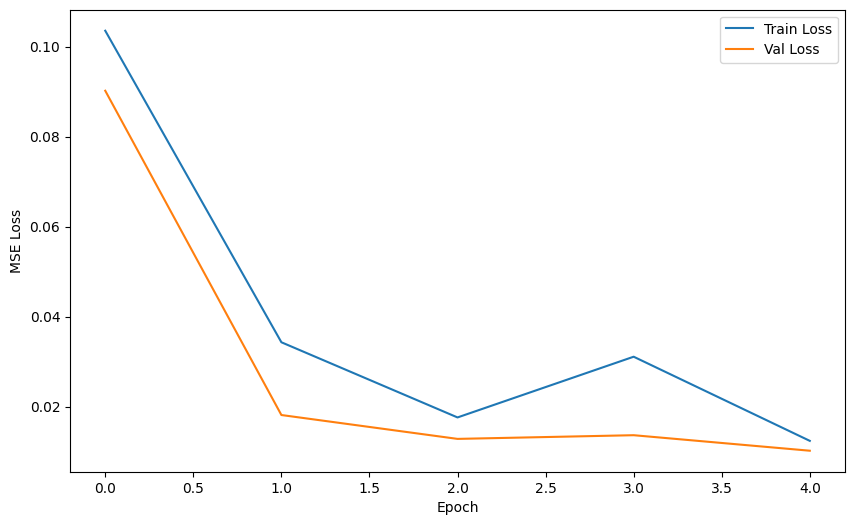

Trial 3 finished: Final Val MAE = 17.2207

Trial 4/10 with config: {'lr': 0.0005, 'batch_size': 16, 'dropout1': 0.2, 'dropout2': 0.3, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   289
Validation batches: 73
Test batches:       91
Epoch 1/5 - Train Loss: 0.0920, Val Loss: 0.0329, MAE: 33.3844, RMSE: 40.7040
Epoch 2/5 - Train Loss: 0.0306, Val Loss: 0.0158, MAE: 21.8929, RMSE: 27.9318
Epoch 3/5 - Train Loss: 0.0179, Val Loss: 0.0121, MAE: 19.4831, RMSE: 24.6552
Epoch 4/5 - Train Loss: 0.0189, Val Loss: 0.0160, MAE: 21.9712, RMSE: 28.2650
Epoch 5/5 - Train Loss: 0.0131, Val Loss: 0.0125, MAE: 18.5348, RMSE: 24.7996


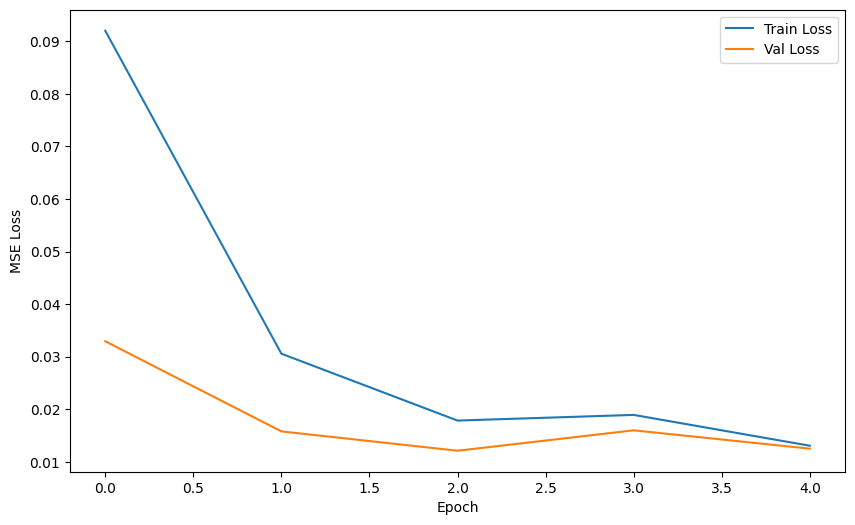

Trial 4 finished: Final Val MAE = 18.5348

Trial 5/10 with config: {'lr': 0.0005, 'batch_size': 32, 'dropout1': 0.4, 'dropout2': 0.1, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   145
Validation batches: 37
Test batches:       46
Epoch 1/5 - Train Loss: 0.0940, Val Loss: 0.0300, MAE: 31.8676, RMSE: 39.1215
Epoch 2/5 - Train Loss: 0.0220, Val Loss: 0.0164, MAE: 22.4797, RMSE: 28.2969
Epoch 3/5 - Train Loss: 0.0199, Val Loss: 0.0350, MAE: 30.5358, RMSE: 42.1970
Epoch 4/5 - Train Loss: 0.0184, Val Loss: 0.0262, MAE: 26.9310, RMSE: 36.4795
Epoch 5/5 - Train Loss: 0.0157, Val Loss: 0.0314, MAE: 30.5339, RMSE: 39.7521


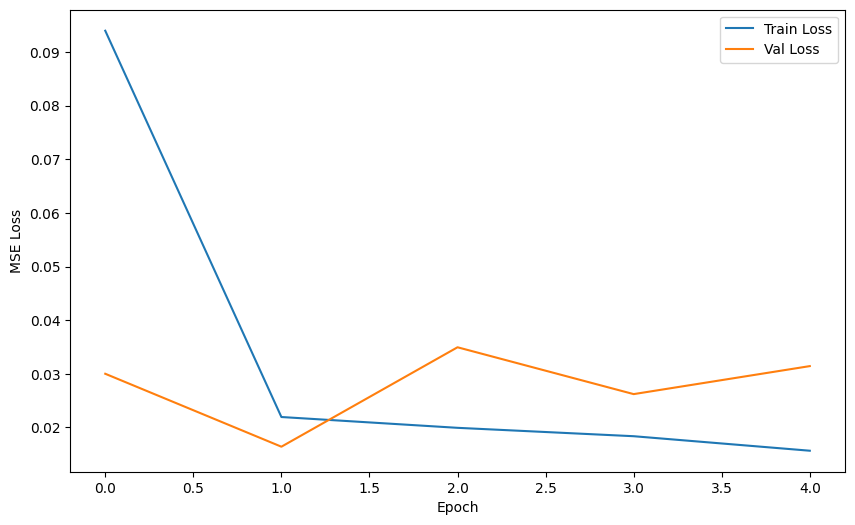

Trial 5 finished: Final Val MAE = 30.5339

Trial 6/10 with config: {'lr': 0.0001, 'batch_size': 32, 'dropout1': 0.4, 'dropout2': 0.1, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   145
Validation batches: 37
Test batches:       46
Epoch 1/5 - Train Loss: 0.1394, Val Loss: 0.0348, MAE: 33.9359, RMSE: 42.0467
Epoch 2/5 - Train Loss: 0.0248, Val Loss: 0.0255, MAE: 28.6905, RMSE: 35.9142
Epoch 3/5 - Train Loss: 0.0175, Val Loss: 0.0165, MAE: 23.0470, RMSE: 29.0631
Epoch 4/5 - Train Loss: 0.0146, Val Loss: 0.0170, MAE: 23.4755, RMSE: 29.4522
Epoch 5/5 - Train Loss: 0.0154, Val Loss: 0.0156, MAE: 21.8894, RMSE: 27.9204


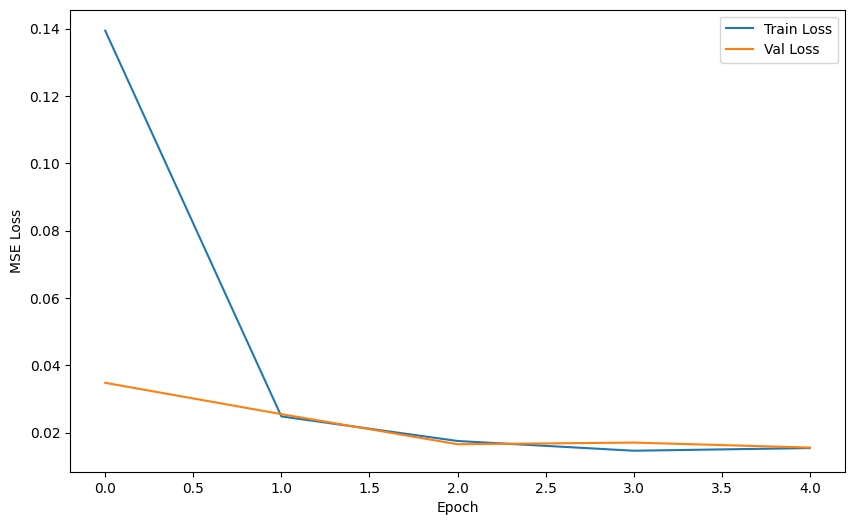

Trial 6 finished: Final Val MAE = 21.8894

Trial 7/10 with config: {'lr': 0.0001, 'batch_size': 16, 'dropout1': 0.2, 'dropout2': 0.3, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   289
Validation batches: 73
Test batches:       91
Epoch 1/5 - Train Loss: 0.0983, Val Loss: 0.0457, MAE: 38.7276, RMSE: 47.8459
Epoch 2/5 - Train Loss: 0.0235, Val Loss: 0.0147, MAE: 21.3843, RMSE: 27.1791
Epoch 3/5 - Train Loss: 0.0175, Val Loss: 0.0207, MAE: 25.3196, RMSE: 32.1038
Epoch 4/5 - Train Loss: 0.0134, Val Loss: 0.0128, MAE: 18.9640, RMSE: 25.3389
Epoch 5/5 - Train Loss: 0.0118, Val Loss: 0.0233, MAE: 24.5955, RMSE: 34.2431


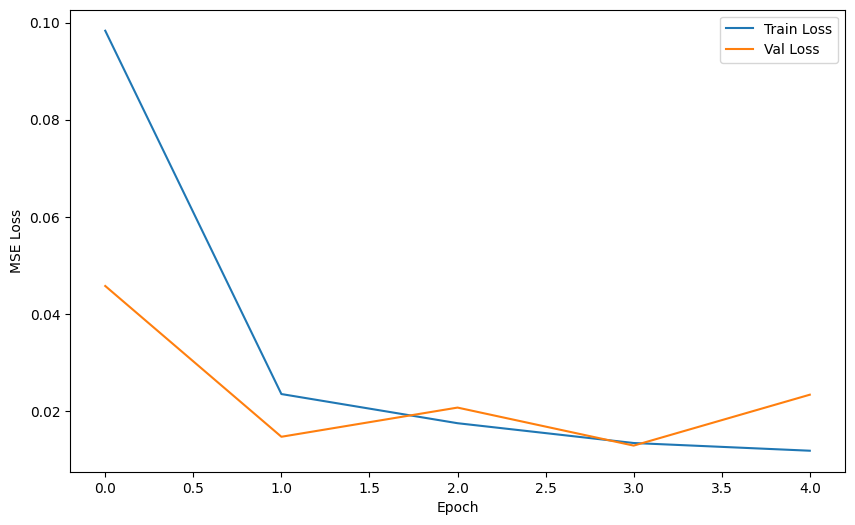

Trial 7 finished: Final Val MAE = 24.5955

Trial 8/10 with config: {'lr': 0.001, 'batch_size': 64, 'dropout1': 0.4, 'dropout2': 0.1, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   73
Validation batches: 19
Test batches:       23
Epoch 1/5 - Train Loss: 0.1053, Val Loss: 0.0286, MAE: 30.5367, RMSE: 38.4085
Epoch 2/5 - Train Loss: 0.0299, Val Loss: 0.0233, MAE: 27.9049, RMSE: 34.8549
Epoch 3/5 - Train Loss: 0.0218, Val Loss: 0.0179, MAE: 23.7575, RMSE: 30.5924
Epoch 4/5 - Train Loss: 0.0158, Val Loss: 0.0126, MAE: 19.3313, RMSE: 24.8907
Epoch 5/5 - Train Loss: 0.0137, Val Loss: 0.0136, MAE: 20.6384, RMSE: 26.5871


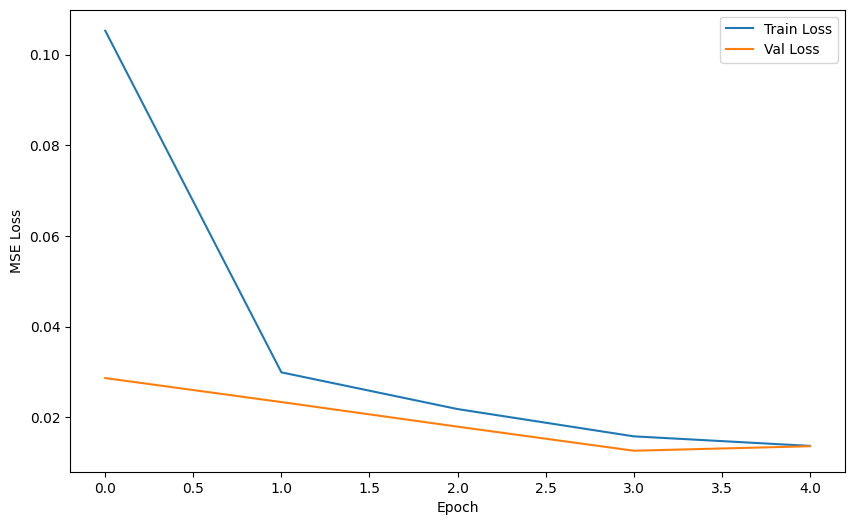

Trial 8 finished: Final Val MAE = 20.6384

Trial 9/10 with config: {'lr': 0.0005, 'batch_size': 16, 'dropout1': 0.4, 'dropout2': 0.2, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   289
Validation batches: 73
Test batches:       91
Epoch 1/5 - Train Loss: 0.0946, Val Loss: 0.0689, MAE: 45.2467, RMSE: 58.8808
Epoch 2/5 - Train Loss: 0.0249, Val Loss: 0.0205, MAE: 25.2114, RMSE: 31.9431
Epoch 3/5 - Train Loss: 0.0205, Val Loss: 0.0133, MAE: 20.1428, RMSE: 25.7566
Epoch 4/5 - Train Loss: 0.0161, Val Loss: 0.0092, MAE: 16.8639, RMSE: 21.2707
Epoch 5/5 - Train Loss: 0.0142, Val Loss: 0.0173, MAE: 23.7829, RMSE: 29.4796


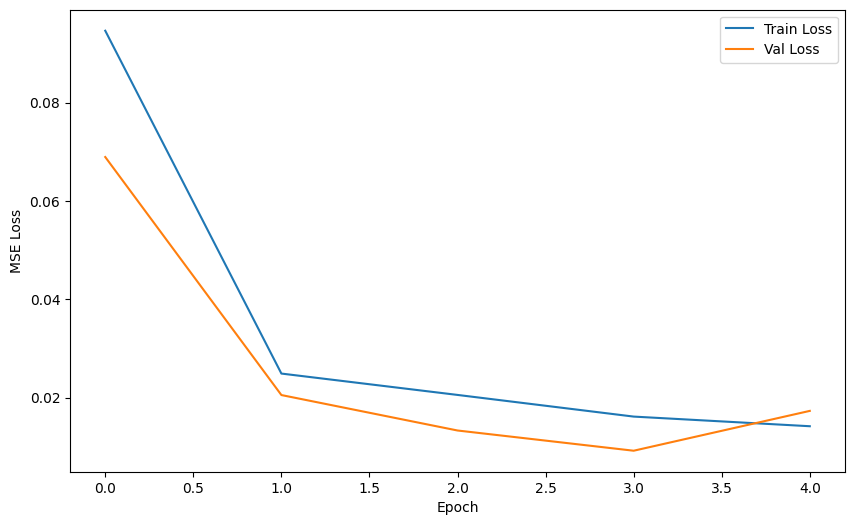

Trial 9 finished: Final Val MAE = 23.7829

Trial 10/10 with config: {'lr': 0.001, 'batch_size': 64, 'dropout1': 0.4, 'dropout2': 0.2, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   73
Validation batches: 19
Test batches:       23
Epoch 1/5 - Train Loss: 0.1187, Val Loss: 0.0624, MAE: 42.2099, RMSE: 55.3831
Epoch 2/5 - Train Loss: 0.0290, Val Loss: 0.0186, MAE: 23.7622, RMSE: 30.6168
Epoch 3/5 - Train Loss: 0.0202, Val Loss: 0.0235, MAE: 27.9555, RMSE: 35.0001
Epoch 4/5 - Train Loss: 0.0153, Val Loss: 0.0119, MAE: 19.0433, RMSE: 24.5589
Epoch 5/5 - Train Loss: 0.0159, Val Loss: 0.0220, MAE: 27.6607, RMSE: 33.9376


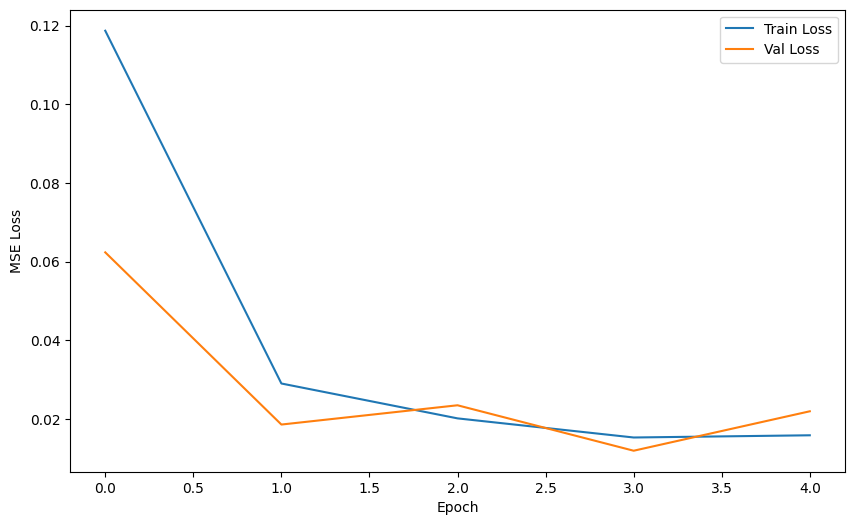

Trial 10 finished: Final Val MAE = 27.6607

Best config: {'lr': 0.001, 'batch_size': 16, 'dropout1': 0.4, 'dropout2': 0.3, 'num_epochs': 5, 'early_stop_patience': 10}, MAE: 16.2496


In [ ]:
# some parameters for complex model
lr_list = [1e-4, 5e-4, 1e-3]
batch_size_list = [16, 32, 64]
dropout1_list = [0.2, 0.3, 0.4]
dropout2_list = [0.1, 0.2, 0.3]

search_results = random_hyperparameter_search(X_coulomb, y_coulomb, lr_list, batch_size_list, dropout1_list, dropout2_list, num_trials=10)


Trial 1/10 with config: {'lr': 0.001, 'batch_size': 64, 'dropout1': 0.2, 'dropout2': 0.2, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   73
Validation batches: 19
Test batches:       23
Epoch 1/5 - Train Loss: 0.1486, Val Loss: 0.0618, MAE: 45.3956, RMSE: 56.9224
Epoch 2/5 - Train Loss: 0.0531, Val Loss: 0.0419, MAE: 37.4814, RMSE: 46.5231
Epoch 3/5 - Train Loss: 0.0369, Val Loss: 0.0535, MAE: 43.6063, RMSE: 52.8768
Epoch 4/5 - Train Loss: 0.0346, Val Loss: 0.0298, MAE: 31.5453, RMSE: 39.5198
Epoch 5/5 - Train Loss: 0.0286, Val Loss: 0.0466, MAE: 38.9726, RMSE: 48.2237


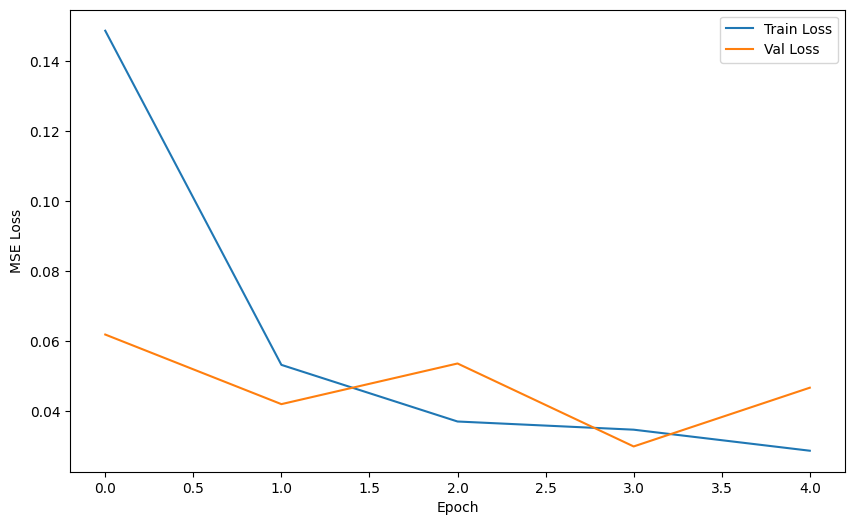

Trial 1 finished: Final Val MAE = 38.9726

Trial 2/10 with config: {'lr': 0.0001, 'batch_size': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   289
Validation batches: 73
Test batches:       91
Epoch 1/5 - Train Loss: 0.2472, Val Loss: 0.0809, MAE: 50.8680, RMSE: 63.8233
Epoch 2/5 - Train Loss: 0.0588, Val Loss: 0.0574, MAE: 43.6792, RMSE: 53.7312
Epoch 3/5 - Train Loss: 0.0435, Val Loss: 0.0415, MAE: 36.7959, RMSE: 45.7418
Epoch 4/5 - Train Loss: 0.0383, Val Loss: 0.0367, MAE: 34.2093, RMSE: 42.9714
Epoch 5/5 - Train Loss: 0.0342, Val Loss: 0.0384, MAE: 35.2957, RMSE: 43.9597


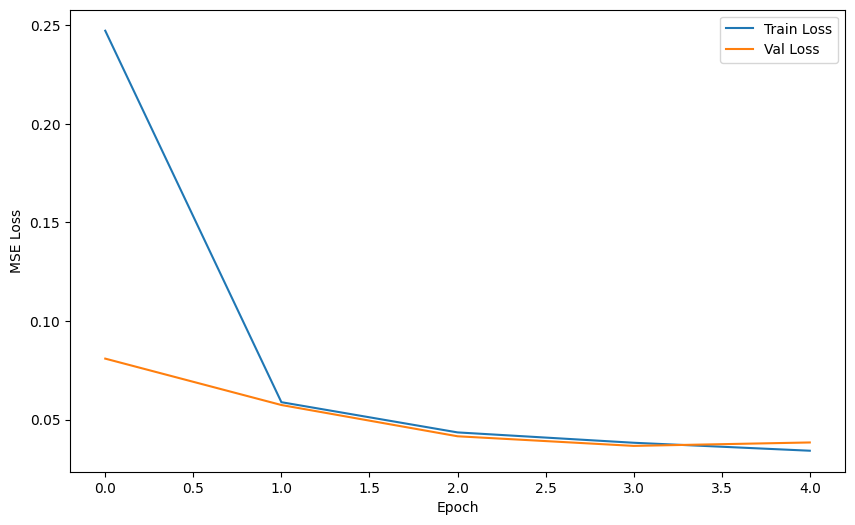

Trial 2 finished: Final Val MAE = 35.2957

Trial 3/10 with config: {'lr': 0.0001, 'batch_size': 32, 'dropout1': 0.3, 'dropout2': 0.3, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   145
Validation batches: 37
Test batches:       46
Epoch 1/5 - Train Loss: 0.2956, Val Loss: 0.0869, MAE: 52.5700, RMSE: 66.4992
Epoch 2/5 - Train Loss: 0.0687, Val Loss: 0.0647, MAE: 45.1546, RMSE: 57.3732
Epoch 3/5 - Train Loss: 0.0538, Val Loss: 0.0503, MAE: 40.4669, RMSE: 50.6485
Epoch 4/5 - Train Loss: 0.0457, Val Loss: 0.0461, MAE: 38.6430, RMSE: 48.5277
Epoch 5/5 - Train Loss: 0.0396, Val Loss: 0.0388, MAE: 36.0683, RMSE: 44.5299


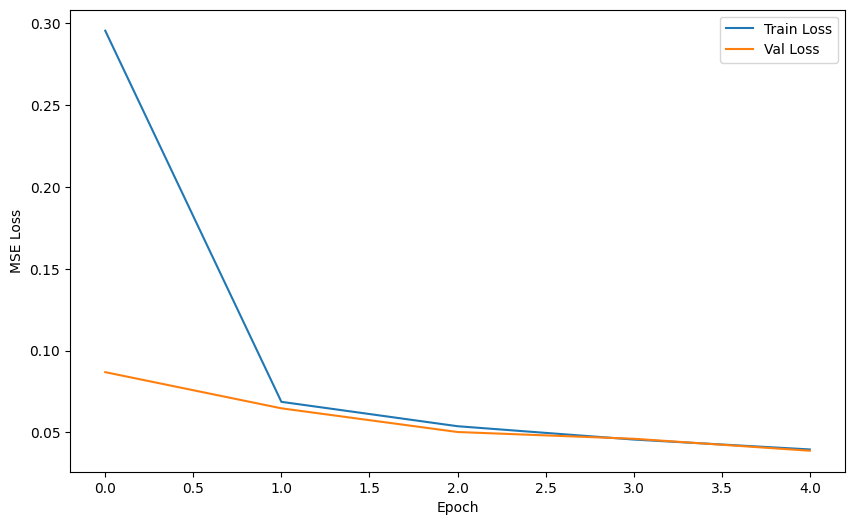

Trial 3 finished: Final Val MAE = 36.0683

Trial 4/10 with config: {'lr': 0.0001, 'batch_size': 16, 'dropout1': 0.4, 'dropout2': 0.2, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   289
Validation batches: 73
Test batches:       91
Epoch 1/5 - Train Loss: 0.2847, Val Loss: 0.0924, MAE: 53.4175, RMSE: 68.1935
Epoch 2/5 - Train Loss: 0.0652, Val Loss: 0.0560, MAE: 42.9128, RMSE: 53.1290
Epoch 3/5 - Train Loss: 0.0487, Val Loss: 0.0489, MAE: 39.6303, RMSE: 49.6154
Epoch 4/5 - Train Loss: 0.0403, Val Loss: 0.0385, MAE: 35.3780, RMSE: 44.0478
Epoch 5/5 - Train Loss: 0.0359, Val Loss: 0.0362, MAE: 34.1611, RMSE: 42.6635


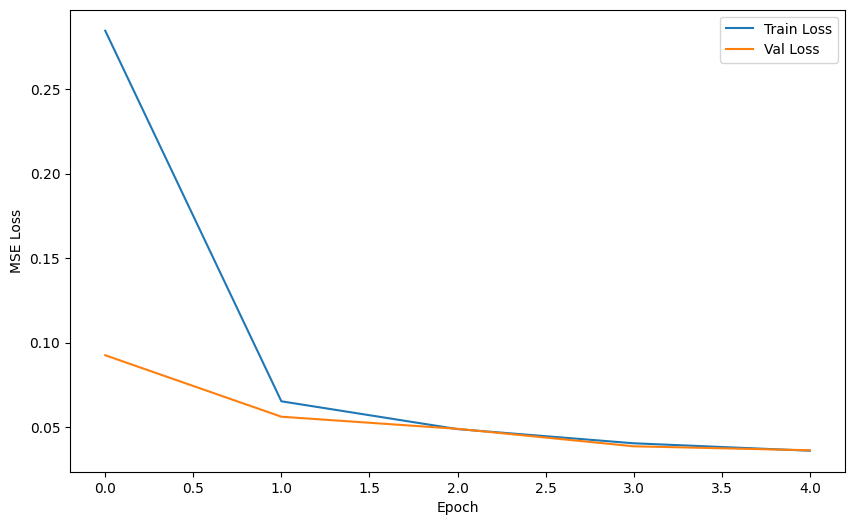

Trial 4 finished: Final Val MAE = 34.1611

Trial 5/10 with config: {'lr': 0.001, 'batch_size': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   145
Validation batches: 37
Test batches:       46
Epoch 1/5 - Train Loss: 0.1290, Val Loss: 0.1177, MAE: 63.5045, RMSE: 76.4564
Epoch 2/5 - Train Loss: 0.0471, Val Loss: 0.0365, MAE: 34.4256, RMSE: 43.0778
Epoch 3/5 - Train Loss: 0.0327, Val Loss: 0.0293, MAE: 30.4295, RMSE: 38.6837
Epoch 4/5 - Train Loss: 0.0310, Val Loss: 0.0260, MAE: 28.8882, RMSE: 36.4132
Epoch 5/5 - Train Loss: 0.0262, Val Loss: 0.0268, MAE: 29.3174, RMSE: 37.0112


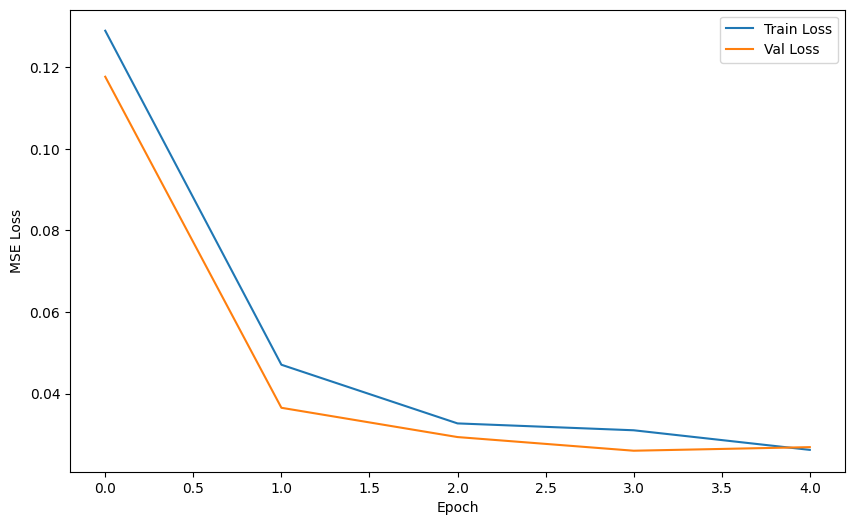

Trial 5 finished: Final Val MAE = 29.3174

Trial 6/10 with config: {'lr': 0.001, 'batch_size': 32, 'dropout1': 0.4, 'dropout2': 0.3, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   145
Validation batches: 37
Test batches:       46
Epoch 1/5 - Train Loss: 0.1660, Val Loss: 0.0752, MAE: 50.1976, RMSE: 61.5634
Epoch 2/5 - Train Loss: 0.0473, Val Loss: 0.0367, MAE: 34.4708, RMSE: 43.2455
Epoch 3/5 - Train Loss: 0.0334, Val Loss: 0.0322, MAE: 32.1690, RMSE: 40.5567
Epoch 4/5 - Train Loss: 0.0293, Val Loss: 0.0301, MAE: 31.2028, RMSE: 39.1910
Epoch 5/5 - Train Loss: 0.0287, Val Loss: 0.0416, MAE: 36.4193, RMSE: 45.7730


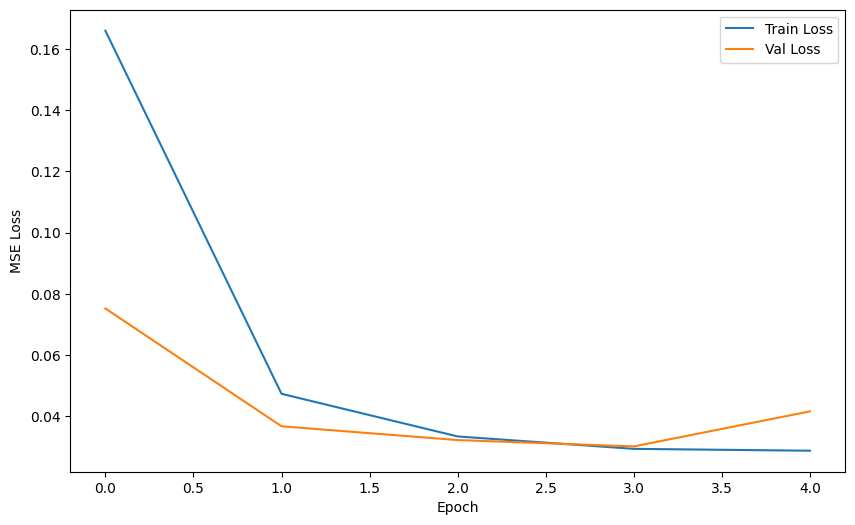

Trial 6 finished: Final Val MAE = 36.4193

Trial 7/10 with config: {'lr': 0.0001, 'batch_size': 32, 'dropout1': 0.3, 'dropout2': 0.1, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   145
Validation batches: 37
Test batches:       46
Epoch 1/5 - Train Loss: 0.2794, Val Loss: 0.1051, MAE: 58.0852, RMSE: 73.1641
Epoch 2/5 - Train Loss: 0.0689, Val Loss: 0.0656, MAE: 46.3424, RMSE: 57.8517
Epoch 3/5 - Train Loss: 0.0538, Val Loss: 0.0521, MAE: 41.4991, RMSE: 51.5166
Epoch 4/5 - Train Loss: 0.0448, Val Loss: 0.0468, MAE: 38.8534, RMSE: 48.7686
Epoch 5/5 - Train Loss: 0.0400, Val Loss: 0.0454, MAE: 38.6728, RMSE: 48.0789


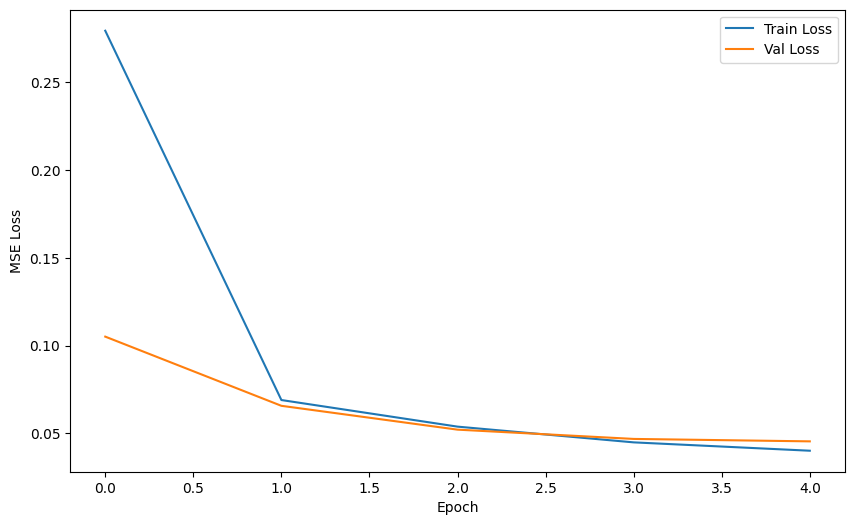

Trial 7 finished: Final Val MAE = 38.6728

Trial 8/10 with config: {'lr': 0.001, 'batch_size': 32, 'dropout1': 0.2, 'dropout2': 0.3, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   145
Validation batches: 37
Test batches:       46
Epoch 1/5 - Train Loss: 0.1508, Val Loss: 0.1233, MAE: 63.6065, RMSE: 79.2683
Epoch 2/5 - Train Loss: 0.0466, Val Loss: 0.0366, MAE: 34.3233, RMSE: 43.2418
Epoch 3/5 - Train Loss: 0.0341, Val Loss: 0.0308, MAE: 31.4251, RMSE: 39.6047
Epoch 4/5 - Train Loss: 0.0312, Val Loss: 0.0381, MAE: 34.2015, RMSE: 43.7775
Epoch 5/5 - Train Loss: 0.0301, Val Loss: 0.0275, MAE: 29.1042, RMSE: 37.4656


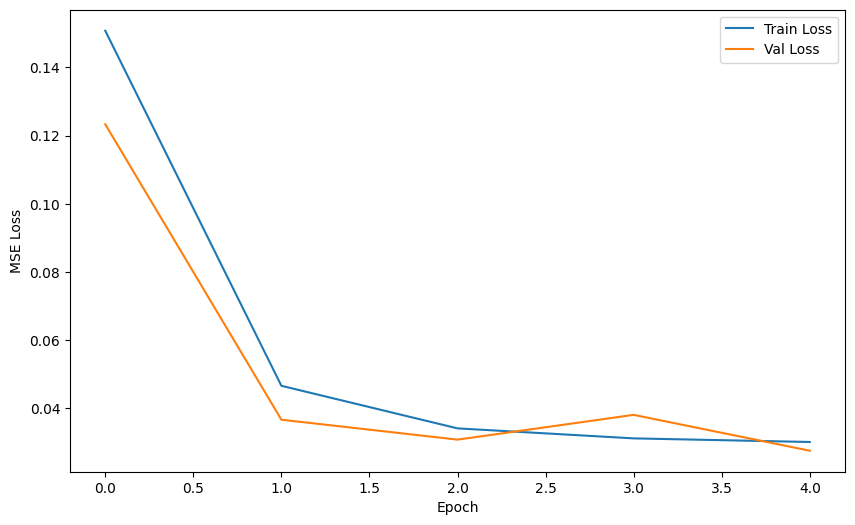

Trial 8 finished: Final Val MAE = 29.1042

Trial 9/10 with config: {'lr': 0.001, 'batch_size': 16, 'dropout1': 0.4, 'dropout2': 0.3, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   289
Validation batches: 73
Test batches:       91
Epoch 1/5 - Train Loss: 0.1713, Val Loss: 0.0463, MAE: 37.5730, RMSE: 48.1579
Epoch 2/5 - Train Loss: 0.0402, Val Loss: 0.0379, MAE: 34.9239, RMSE: 43.6076
Epoch 3/5 - Train Loss: 0.0317, Val Loss: 0.0296, MAE: 29.7978, RMSE: 38.4976
Epoch 4/5 - Train Loss: 0.0287, Val Loss: 0.0241, MAE: 27.7460, RMSE: 34.8206
Epoch 5/5 - Train Loss: 0.0290, Val Loss: 0.0317, MAE: 30.7537, RMSE: 39.8087


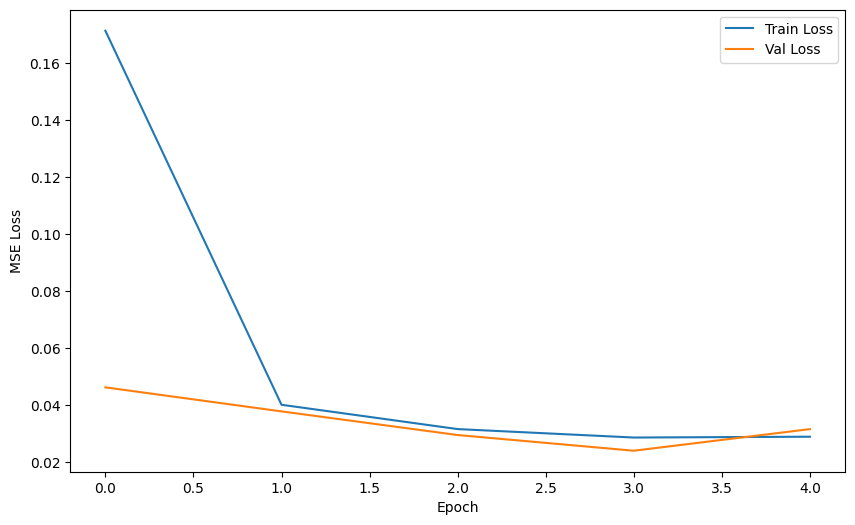

Trial 9 finished: Final Val MAE = 30.7537

Trial 10/10 with config: {'lr': 0.0005, 'batch_size': 16, 'dropout1': 0.3, 'dropout2': 0.1, 'num_epochs': 5, 'early_stop_patience': 10}
Training batches:   289
Validation batches: 73
Test batches:       91
Epoch 1/5 - Train Loss: 0.1718, Val Loss: 0.0829, MAE: 50.5589, RMSE: 64.3571
Epoch 2/5 - Train Loss: 0.0436, Val Loss: 0.0418, MAE: 35.9243, RMSE: 45.8210
Epoch 3/5 - Train Loss: 0.0357, Val Loss: 0.0317, MAE: 31.5308, RMSE: 39.9444
Epoch 4/5 - Train Loss: 0.0324, Val Loss: 0.0285, MAE: 30.0824, RMSE: 37.8875
Epoch 5/5 - Train Loss: 0.0270, Val Loss: 0.0310, MAE: 31.7464, RMSE: 39.4866


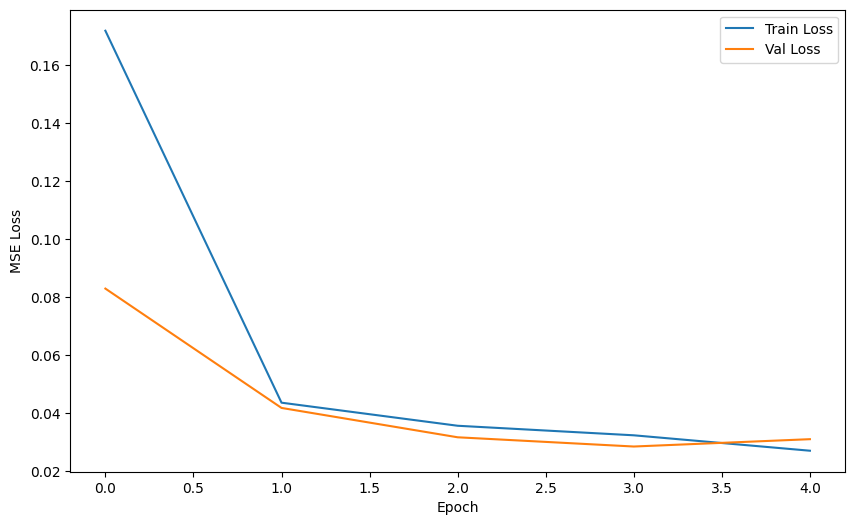

Trial 10 finished: Final Val MAE = 31.7464

Best config: {'lr': 0.001, 'batch_size': 32, 'dropout1': 0.2, 'dropout2': 0.3, 'num_epochs': 5, 'early_stop_patience': 10}, MAE: 29.1042


In [ ]:
# some parameters for simple model
lr_list = [1e-4, 5e-4, 1e-3]
batch_size_list = [16, 32, 64]
dropout1_list = [0.2, 0.3, 0.4]
dropout2_list = [0.1, 0.2, 0.3]

search_results = random_hyperparameter_search(X_coulomb, y_coulomb, lr_list, batch_size_list, dropout1_list, dropout2_list, num_trials=10)

# Final Model Training
Use the best config, we train the model to observe the MAE.

For the complex model with MSELoss, the MAE ranges between 8.6-9.9 kcal/mol.

For the medium-complexity model with MSELoss, the MAE is around 14 kcal/mol.

We also tried a simple model and the simple model achieves a MAE around 17 kcal/mol.

Training batches:   289
Validation batches: 73
Test batches:       91
Epoch 1/100 - Train Loss: 0.1225, Val Loss: 0.0643, MAE: 44.9031, RMSE: 56.7848
Epoch 6/100 - Train Loss: 0.0126, Val Loss: 0.0077, MAE: 15.0289, RMSE: 19.6060
Epoch 11/100 - Train Loss: 0.0109, Val Loss: 0.0112, MAE: 19.6397, RMSE: 23.7438
Epoch 16/100 - Train Loss: 0.0067, Val Loss: 0.0095, MAE: 16.6980, RMSE: 21.7784
Epoch 21/100 - Train Loss: 0.0066, Val Loss: 0.0042, MAE: 10.6508, RMSE: 14.4386
Epoch 26/100 - Train Loss: 0.0056, Val Loss: 0.0131, MAE: 18.6846, RMSE: 25.3046
Epoch 31/100 - Train Loss: 0.0054, Val Loss: 0.0043, MAE: 10.3761, RMSE: 14.7417
Epoch 36/100 - Train Loss: 0.0023, Val Loss: 0.0045, MAE: 11.2706, RMSE: 15.0512
Epoch 41/100 - Train Loss: 0.0033, Val Loss: 0.0032, MAE: 9.2757, RMSE: 12.7850
Epoch 46/100 - Train Loss: 0.0035, Val Loss: 0.0044, MAE: 11.1288, RMSE: 14.9446
Epoch 51/100 - Train Loss: 0.0006, Val Loss: 0.0033, MAE: 9.0816, RMSE: 12.7882
Epoch 56/100 - Train Loss: 0.0003, Val Loss

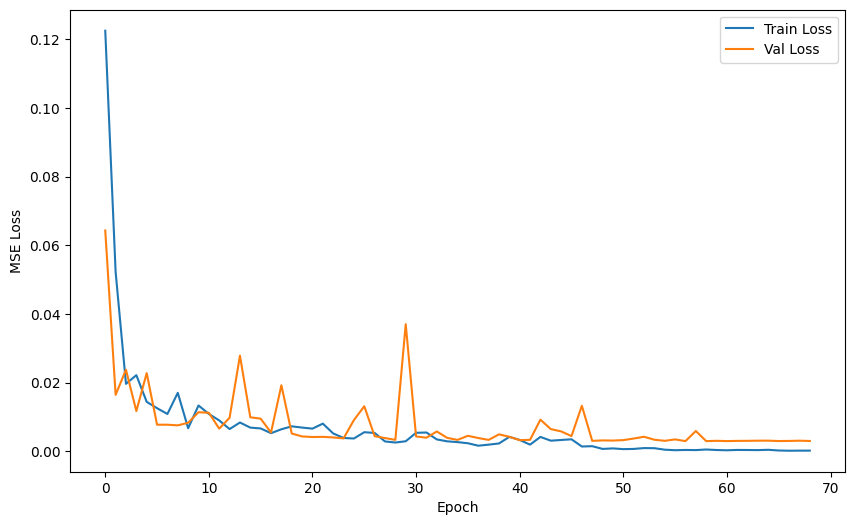

Test Loss: 0.002902874180658178
Test MAE: 8.59899
Test RMSE: 12.032767


In [22]:
# Complex model with MSE loss
criterion = nn.MSELoss() # MSE

Best_config = {'lr': 0.001, 'batch_size': 16, 'dropout1': 0.4, 'dropout2': 0.3, 'num_epochs': 100, 'early_stop_patience': 10}
results = train_coulomb_cnn(Best_config, X_coulomb, y_coulomb)

loss, mae, rmse = evaluate(results['model'], results['test_loader'], criterion, device, scaler=results['scaler'])
print("Test Loss:", loss)
print("Test MAE:", mae)
print("Test RMSE:", rmse)

Training batches:   145
Validation batches: 37
Test batches:       46
Epoch 1/150 - Train Loss: 0.3104, Val Loss: 0.0668, MAE: 46.8146, RMSE: 58.2569
Epoch 6/150 - Train Loss: 0.0230, Val Loss: 0.0234, MAE: 27.1755, RMSE: 34.5128
Epoch 11/150 - Train Loss: 0.0195, Val Loss: 0.0194, MAE: 24.7512, RMSE: 31.2477
Epoch 16/150 - Train Loss: 0.0152, Val Loss: 0.0229, MAE: 27.8221, RMSE: 33.7852
Epoch 21/150 - Train Loss: 0.0130, Val Loss: 0.0143, MAE: 20.9654, RMSE: 26.8180
Epoch 26/150 - Train Loss: 0.0123, Val Loss: 0.0187, MAE: 24.6125, RMSE: 30.3632
Epoch 31/150 - Train Loss: 0.0096, Val Loss: 0.0117, MAE: 18.8688, RMSE: 24.0958
Epoch 36/150 - Train Loss: 0.0089, Val Loss: 0.0114, MAE: 18.6168, RMSE: 23.8670
Epoch 41/150 - Train Loss: 0.0075, Val Loss: 0.0100, MAE: 17.4440, RMSE: 22.3242
Epoch 46/150 - Train Loss: 0.0066, Val Loss: 0.0093, MAE: 16.8276, RMSE: 21.4225
Epoch 51/150 - Train Loss: 0.0059, Val Loss: 0.0101, MAE: 17.4319, RMSE: 22.2468
Epoch 56/150 - Train Loss: 0.0049, Val Lo

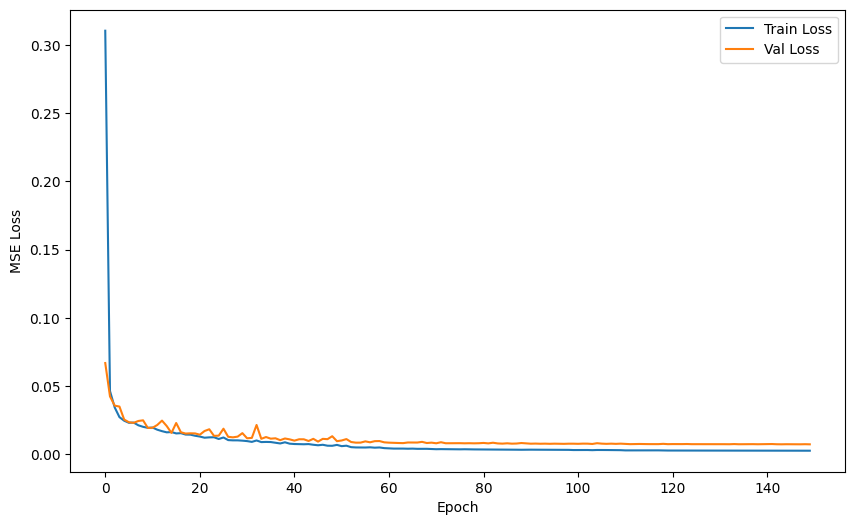

In [ ]:
# Medium Complexity model with MSE loss
criterion = nn.MSELoss() # MSE

Best_config = {'lr': 0.0001, 'batch_size': 32, 'dropout1': 0.3, 'dropout2': 0.2, 'num_epochs': 150, 'early_stop_patience': 10}
results = train_coulomb_cnn(Best_config, X_coulomb, y_coulomb)

loss, mae, rmse = evaluate(results['model'], results['test_loader'], criterion, device, scaler=results['scaler'])
print("Test Loss:", loss)
print("Test MAE:", mae)
print("Test RMSE:", rmse)

Training batches:   145
Validation batches: 37
Test batches:       46
Epoch 1/150 - Train Loss: 0.1948, Val Loss: 0.0680, MAE: 47.4753, RMSE: 58.8625
Epoch 6/150 - Train Loss: 0.0294, Val Loss: 0.0292, MAE: 30.7857, RMSE: 38.4980
Epoch 11/150 - Train Loss: 0.0236, Val Loss: 0.0236, MAE: 27.6592, RMSE: 34.6142
Epoch 16/150 - Train Loss: 0.0198, Val Loss: 0.0192, MAE: 24.6969, RMSE: 31.2437
Epoch 21/150 - Train Loss: 0.0165, Val Loss: 0.0164, MAE: 22.9633, RMSE: 28.9080
Epoch 26/150 - Train Loss: 0.0131, Val Loss: 0.0156, MAE: 22.7688, RMSE: 28.1343
Epoch 31/150 - Train Loss: 0.0118, Val Loss: 0.0155, MAE: 21.9624, RMSE: 28.1123
Epoch 36/150 - Train Loss: 0.0115, Val Loss: 0.0124, MAE: 19.5365, RMSE: 25.0361
Epoch 41/150 - Train Loss: 0.0092, Val Loss: 0.0122, MAE: 19.3318, RMSE: 24.6623
Epoch 46/150 - Train Loss: 0.0086, Val Loss: 0.0132, MAE: 20.0311, RMSE: 25.4881
Epoch 51/150 - Train Loss: 0.0079, Val Loss: 0.0110, MAE: 18.5937, RMSE: 23.5177
Epoch 56/150 - Train Loss: 0.0073, Val Lo

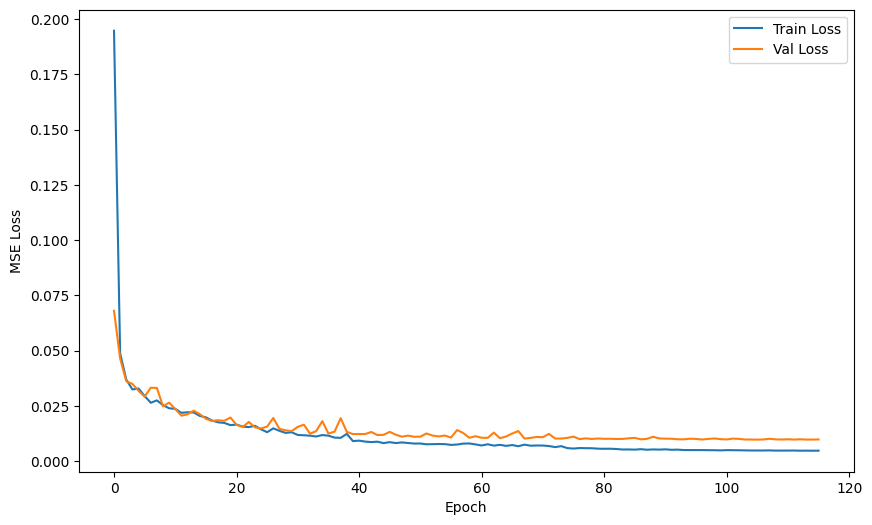

Test Loss: 0.010775841190479696
Test MAE: 17.649324
Test RMSE: 23.009373


In [20]:
# Simple model with MSE Loss
criterion = nn.MSELoss() # MSE

Best_config = {'lr': 0.0003, 'batch_size': 32, 'dropout1': 0.2, 'dropout2': 0.3, 'num_epochs': 150, 'early_stop_patience': 10}
results = train_coulomb_cnn(Best_config, X_coulomb, y_coulomb)

loss, mae, rmse = evaluate(results['model'], results['test_loader'], criterion, device, scaler=results['scaler'])
print("Test Loss:", loss)
print("Test MAE:", mae)
print("Test RMSE:", rmse)